<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/LHMProgram/blob/main/Ana_Alonso_LMHSS23_AAI_Week1_Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you generate faces?
##### We expect you to use images to generate new ones with a Generative Model of your choice. You have to write a dataloader to read images from the folder 'cropped/', write a Generative Model class, a loss function, a training loop, and visualize your generated images.

In [2]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data).

In [3]:
!wget https://www.dropbox.com/s/g0w7a3x1aw3oonf/SimpsonFaces.zip?dl=0

!unzip SimpsonFaces.zip?dl=0

!ls

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cropped/._4084.png  
  inflating: cropped/3933.png        
  inflating: __MACOSX/cropped/._3933.png  
  inflating: cropped/2393.png        
  inflating: __MACOSX/cropped/._2393.png  
  inflating: cropped/1842.png        
  inflating: __MACOSX/cropped/._1842.png  
  inflating: cropped/4912.png        
  inflating: __MACOSX/cropped/._4912.png  
  inflating: cropped/326.png         
  inflating: __MACOSX/cropped/._326.png  
  inflating: cropped/440.png         
  inflating: __MACOSX/cropped/._440.png  
  inflating: cropped/9588.png        
  inflating: __MACOSX/cropped/._9588.png  
  inflating: cropped/8696.png        
  inflating: __MACOSX/cropped/._8696.png  
  inflating: cropped/6863.png        
  inflating: __MACOSX/cropped/._6863.png  
  inflating: cropped/454.png         
  inflating: __MACOSX/cropped/._454.png  
  inflating: cropped/8682.png        
  inflating: __MACOSX/cropped/._8682.png  
  inflating: cropp

## Dataloader
####  Write a dataloader to read images from the folder 'cropped/' (Note that the transform *trans* resizes the images to 32x32)

In [4]:
# First the transformation that need to be done. To tensor and resizing the images
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    # Creating a list of file paths to the images stored in the image_path directory.
    # To join the directory path with each file name obtained from the list
    self.images = [os.path.join(image_path,x) for x in os.listdir(image_path)]
    self.transform = transform

  # Taking the lenght of the images
  def __len__(self):
    return len(self.images)

  # Returning the corresponding 'idx' image
  def __getitem__(self,idx):
    im = Image.open(self.images[idx])
    im=np.array(im)
    im = self.transform(im)
    return im

In [5]:
# Calling the class with the image_path
dataset = MyDataset("cropped/")

# Setting a batch size
batch_size = 32
# Creating the training loader
train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

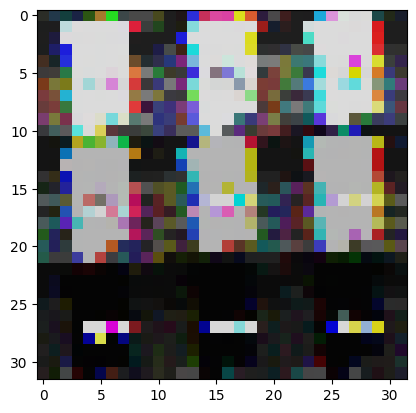

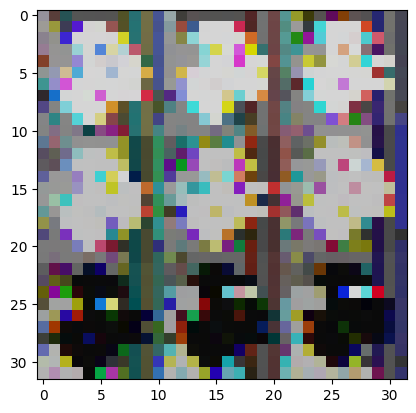

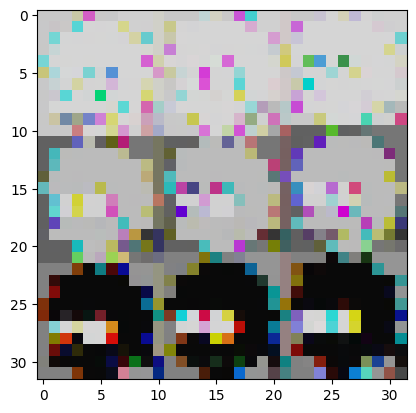

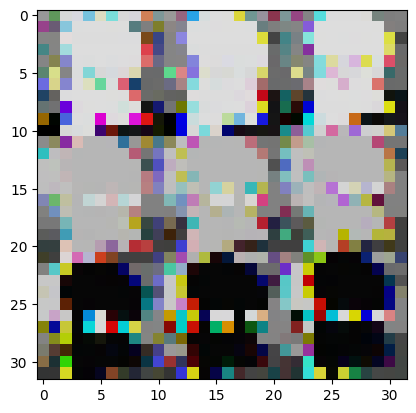

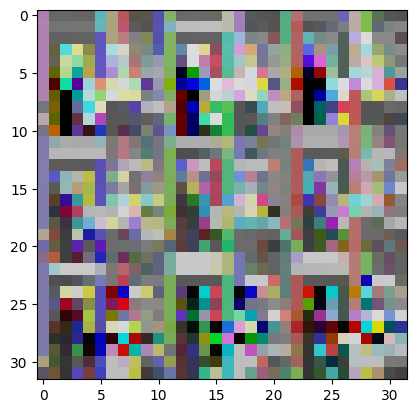

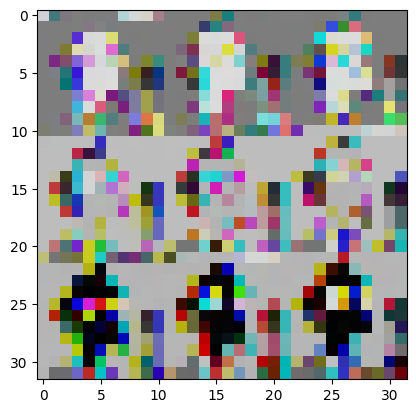

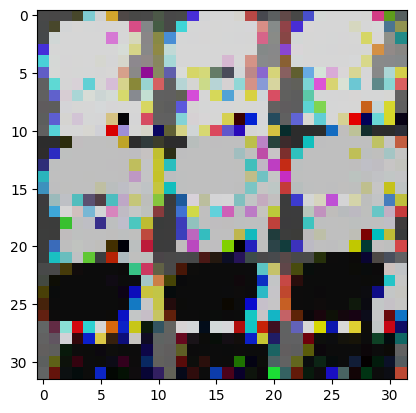

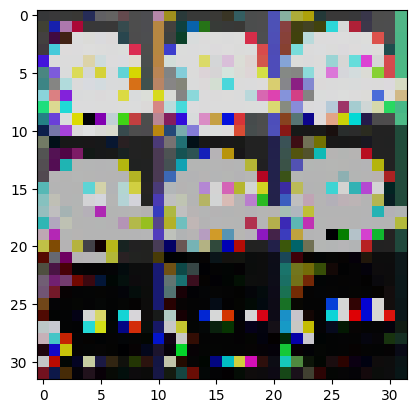

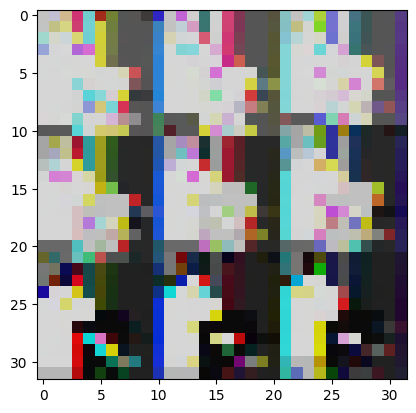

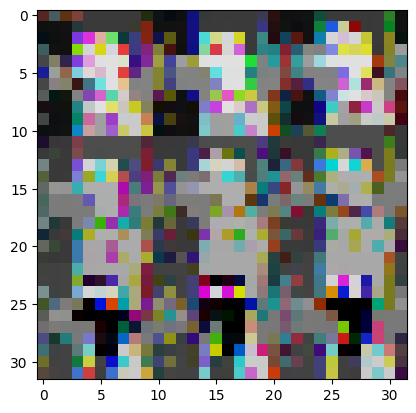

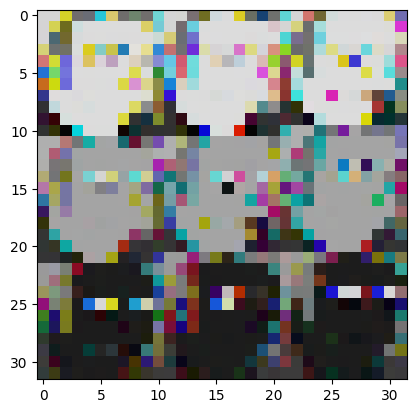

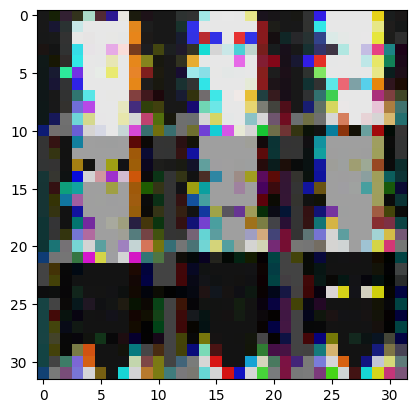

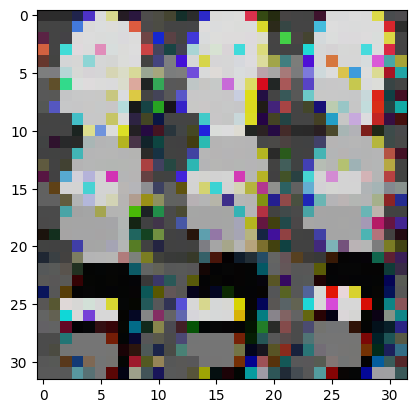

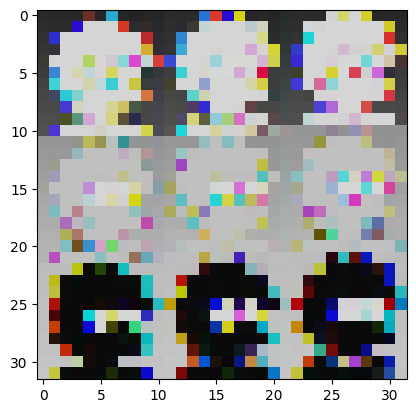

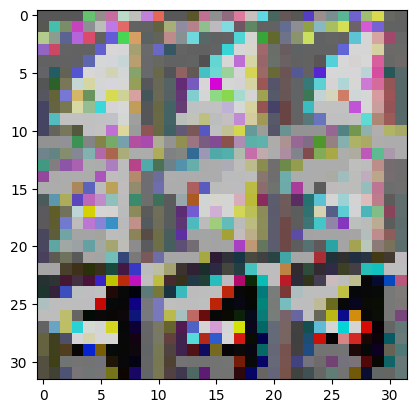

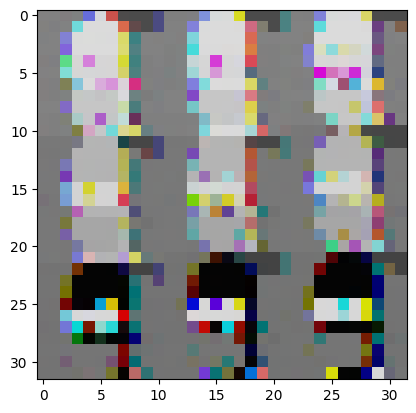

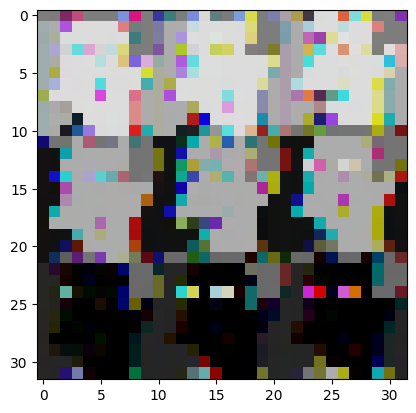

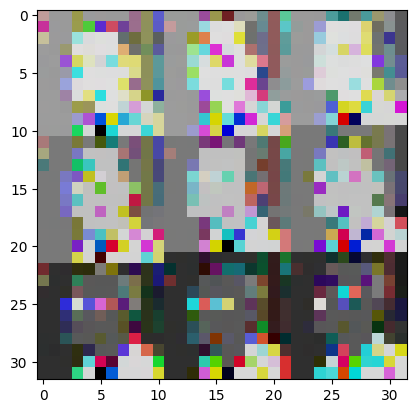

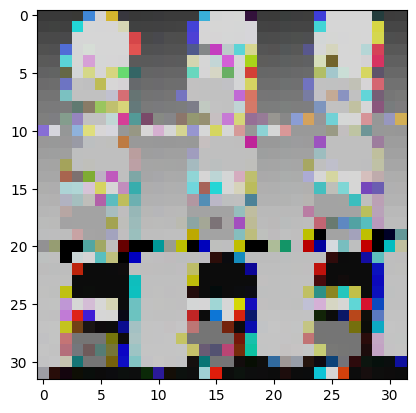

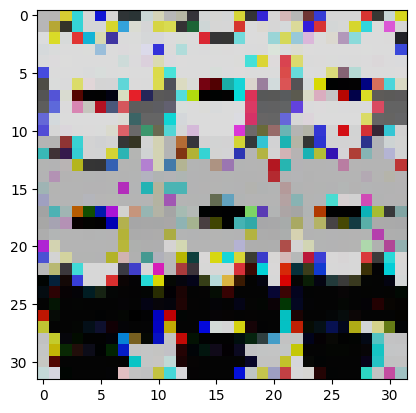

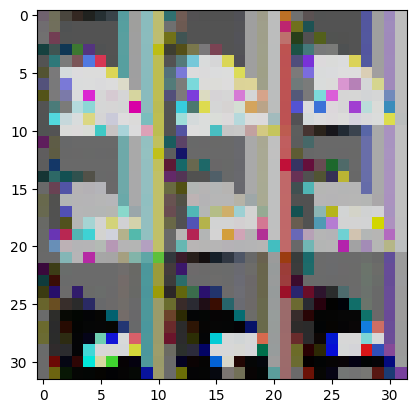

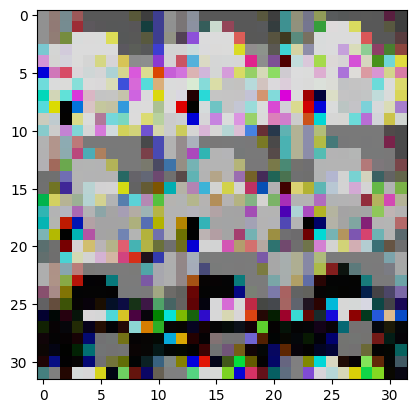

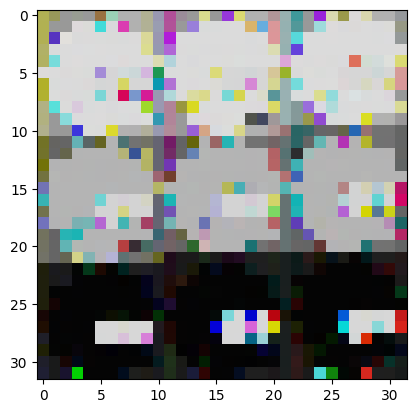

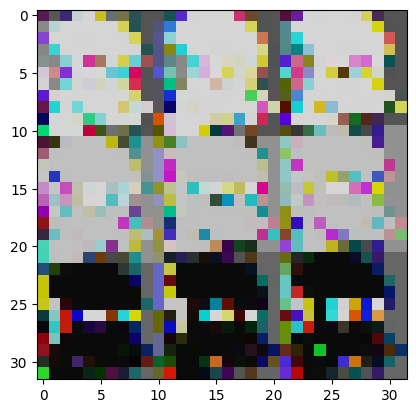

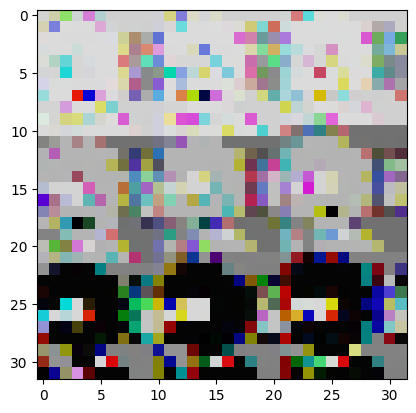

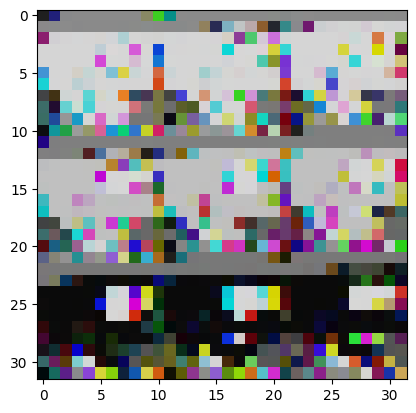

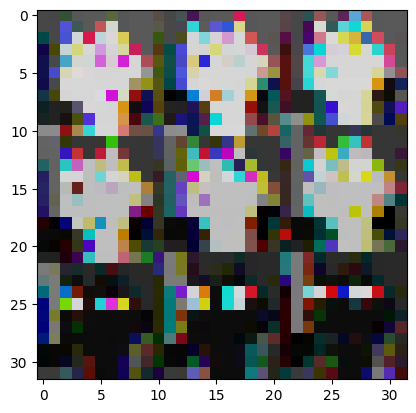

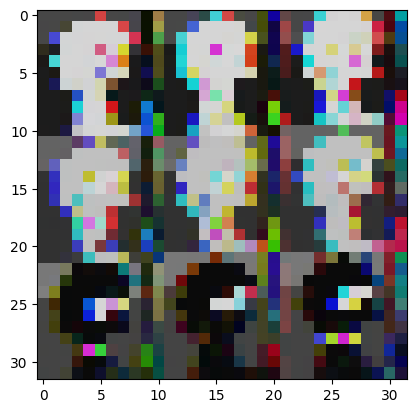

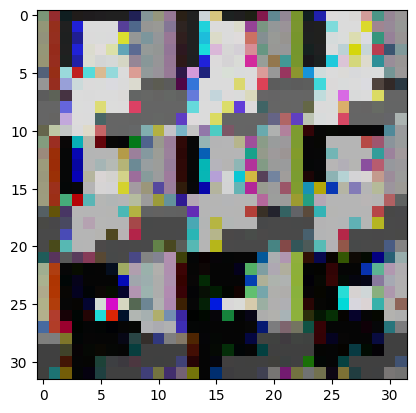

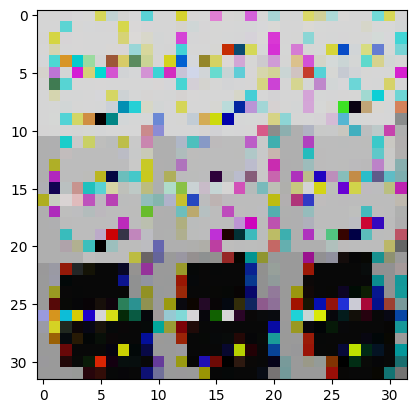

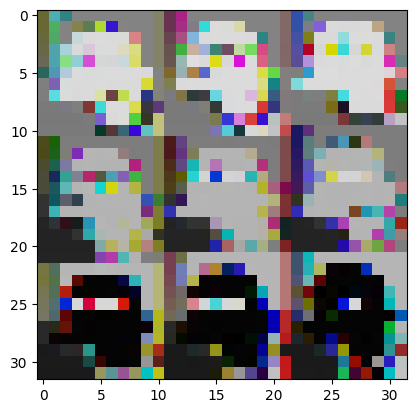

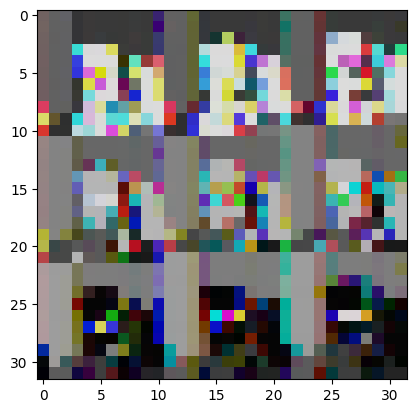

In [7]:
# Visualize an entire batch of data
for batch in train_loader:
  for image in batch:
    plt.imshow(image.view(32,32,3))
    plt.show()
  break

### Generative Model class
#### Write a Generative Model class in the following cell

In [8]:
# Class for Image generator using GAN's
class ImageGenerator(nn.Module):
    def __init__(self, input_dim, image_channels, layer_size):
        super(ImageGenerator, self).__init__()
        self.generator = nn.Sequential(
            # Calls for a function that creates an entire block for the generator to reduce the code
            self.create_gen_block(input_dim, layer_size * 4),
            self.create_gen_block(layer_size * 4, layer_size * 2),
            self.create_gen_block(layer_size * 2, layer_size),
            self.create_gen_block(layer_size, image_channels * 32 * 32, final_layer=True)  # Last layer without BatchNorm and using Tanh
        )

    # Create Generator Block Function
    def create_gen_block(self, in_dim, out_dim, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(inplace=True),
            )
        else:
          # Last generator layer
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.Tanh(),
            )

    # Return the reshaped tensor (batch of generated images)
    def forward(self, input_noise):
        return self.generator(input_noise).view(len(input_noise), 3, 32, 32)

# Class for Image discriminator using GAN's
class ImageDiscriminator(nn.Module):
    def __init__(self, image_channels, layer_size):
        super(ImageDiscriminator, self).__init__()
        self.discriminator = nn.Sequential(
            # Calls for a function that creates an entire block for the discriminator to reduce the code
            # input_dim must be => image_channels * width * height
            self.create_disc_block(image_channels * 32 * 32, layer_size),
            self.create_disc_block(layer_size, layer_size * 2),
            self.create_disc_block(layer_size * 2, 1, final_layer=True),
        )

    # Create Discriminator Block Function
    def create_disc_block(self, in_dim, out_dim, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
          # Last discriminator layer
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
            )

    # Reshape the image into a 1D tensor, passes it through the discriminator
    # returns the likelihood or score of the input image being real
    def forward(self, input_image):
        return self.discriminator(input_image.view(len(input_image), -1))

## Loss
#### Define Loss function in the following cell

In [16]:
# Tried with MSELoss at the begging but did not generate good images
# After searching for info I decided to use binary cross entropy loss with logits
criterion = nn.BCEWithLogitsLoss()

### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

In [26]:
# Trying to connect to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 100 # Noise vector size
num_epochs = 15
lr = 1e-3 # Learning rate
image_channels = 3 # RGB
layer_size = 128 # Number of neurons in the hidden layers
img_generator = ImageGenerator(nz, image_channels, layer_size).to(device)
img_discriminator = ImageDiscriminator(image_channels, layer_size).to(device)

# Applying Adam optimizer to the generator and the discriminator
generator_opt = torch.optim.Adam(img_generator.parameters())
discriminator_opt = torch.optim.Adam(img_discriminator.parameters())

# Training Loop
for epoch in range(num_epochs):
    for real in train_loader:
        real = real.to(device) # Real images to the device

        # Discriminator
        noise = torch.randn(batch_size, nz).to(device)
        fake = img_generator(noise) # Fake image generator

        # Prediction and Loss calculation for fake images
        disc_fake_pred = img_discriminator(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # Loss calculation for real images
        disc_real_pred = img_discriminator(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        discriminator_loss = (disc_fake_loss + disc_real_loss) / 2

        # Backpropagate the discriminator loss and update the parameters
        img_discriminator.zero_grad()
        discriminator_loss.backward()
        discriminator_opt.step()

        # Get the new predictions and generator loss
        disc_fake_pred = img_discriminator(fake)
        generator_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        # Backpropagate the generator loss and update the parameters
        img_generator.zero_grad()
        generator_loss.backward()
        generator_opt.step()

    print(f"Epoch: [{epoch + 1}/{num_epochs}] Dis Loss: {discriminator_loss}, Gen Loss: {generator_loss}")

Epoch: [1/15] Dis Loss: 0.10834602266550064, Gen Loss: 8.13807201385498
Epoch: [2/15] Dis Loss: 0.2103118896484375, Gen Loss: 5.154263973236084
Epoch: [3/15] Dis Loss: 0.22163280844688416, Gen Loss: 5.4963178634643555
Epoch: [4/15] Dis Loss: 0.4081733226776123, Gen Loss: 2.1663010120391846
Epoch: [5/15] Dis Loss: 0.43012547492980957, Gen Loss: 5.414616107940674
Epoch: [6/15] Dis Loss: 0.4640529453754425, Gen Loss: 6.3556623458862305
Epoch: [7/15] Dis Loss: 0.8844635486602783, Gen Loss: 2.791712522506714
Epoch: [8/15] Dis Loss: 0.39621010422706604, Gen Loss: 1.921936273574829
Epoch: [9/15] Dis Loss: 0.3285917341709137, Gen Loss: 2.7007482051849365
Epoch: [10/15] Dis Loss: 0.42398250102996826, Gen Loss: 8.732442855834961
Epoch: [11/15] Dis Loss: 0.7762901782989502, Gen Loss: 5.284844398498535
Epoch: [12/15] Dis Loss: 2.081329584121704, Gen Loss: 1.3433870077133179
Epoch: [13/15] Dis Loss: 1.2221245765686035, Gen Loss: 1.4051949977874756
Epoch: [14/15] Dis Loss: 0.1933748424053192, Gen Lo

## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

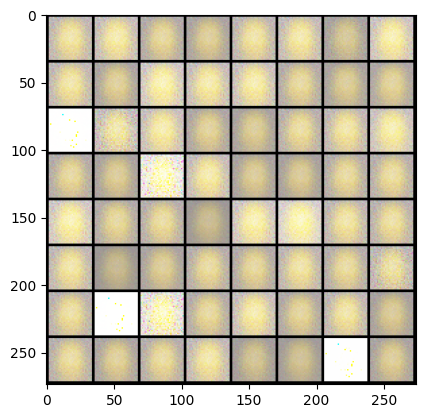

In [27]:
# Visualize generated images
import matplotlib.pyplot as plt

batch_size = 64

# Generate images using random noise
noise = torch.randn(batch_size, nz).to(device)
generated_images = img_generator(noise)

# Grid of images from the tensor of the generated images detaching the tensor
# and normalizing the pixels between [0 1]
grid_img = make_grid(generated_images.cpu().detach(), normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()